# Empirical exploration of ensemble methods

### Questions
> 1. Apply sklearn DecisionTreeClassifier on the egg-yoke dataset and visualize the results with `visualize_classifier` and with sklearn plot_tree.
> 2. By following the algorithm explained [here](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms), retrace the steps that led to this tree.
> 3. The egg-yoke dataset was produced with the sklearn function make_circle. The parameters noise and factor where set to produce a separable dataset. Try noise = 0 to understand how the data is generated. Generate new train and test sets with noise=0.2, factor=0.25, to make the problem more difficult. Fit a tree, visualize and compute generalization error. Generate another train set and repeat. What do you observe.
> 4. *Random forest:* Boostrap allows the simulation of several training samples, by picking n out of m examples with replacement. Bootstrap aggregating (Bagging) classifiers is an ensemble learning methods, which combines the predictors obtained by the same model over bootstraped version of the train set (see Bishop p.656). In the following experiment you will keep only one train set and the test set from the previous question. 
>     1. Using numpy randint, boostrap the train set to obtained two resampled train sets of size 3/4th that of the original dataset. Fit a tree in each resampled train set, visualize and compute generalization error. Combine the decision of both predictors and compute generalization error of the combination.
>     2. Repeat the experiment on a larger scale by using sklearn BaggingClassifier

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    ax.grid()
    return ax

# Question 1 : 
##### Apply sklearn DecisionTreeClassifier on the egg-yoke dataset and visualize the results with `visualize_classifier` and with sklearn plot_tree.

In [4]:
# Importing the data
import pandas as pd

# Load test and train data (replacing -1 labels with 0)
test_data = pd.read_csv("../data/eggyoke_testdata.csv")
X_test = test_data[["x_1", "x_2"]]
y_test = test_data["y"]
y_test.replace(-1, 0, inplace=True)

train_data = pd.read_csv("../data/eggyoke_traindata.csv")
X_train = train_data[["x_1", "x_2"]]
y_train = train_data["y"]
y_train.replace(-1, 0, inplace=True)

In [5]:
from sklearn import tree
model = tree.DecisionTreeClassifier(criterion='gini', max_depth=10)
model.fit(X_train.values, y_train.values)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

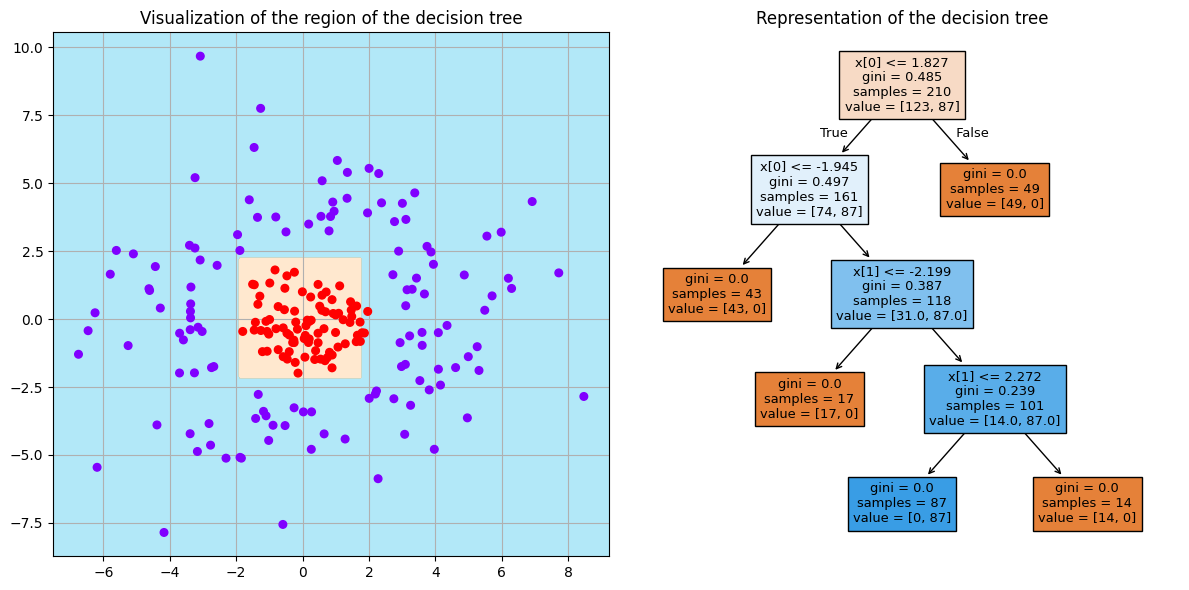

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

visualize_classifier(model, X_test.values, y_test.values, ax=axes[0])
axes[0].set_title("Visualization of the region of the decision tree")

tree.plot_tree(model, filled=True, ax=axes[1])
axes[1].set_title("Representation of the decision tree")

plt.tight_layout()
plt.show()

In [7]:
## Let's evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_test.values)
generalization_error = 1 - accuracy_score(y_test.values, y_pred)
conf_matrix = confusion_matrix(y_test.values, y_pred)
print("Generalization error:", round(generalization_error, 2))
print("Confusion matrix", conf_matrix)

Generalization error: 0.01
Confusion matrix [[125   0]
 [  2  84]]


# Question 2

#### Explaining the tree from this algorithm

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

# How the Tree Algorithm Works

**Three stopping conditions:**
- `max_depth` is reached
- the number of samples $n_m$ in a node becomes smaller than the parameter `min_samples_split`
- the impurity becomes smaller than the parameter `min_impurity_decrease`

**How it is computed:**  
At the root node, we took all the points of the training dataset. Then, for each node $m$:  

- A feature $x_j$ is selected, with $x = (x_1, x_2, \dots, x_d)$ and $1 \le j \le d$,  
- A threshold $t_m$ is choose, such that if $x_j \le t_m$ $x_i$ belongs to the left child node, otherwise to the right child node.

$$Q_m^{\text{left}}(\theta) = \{(x, y) \mid x_j \le t_m\}$$
$$Q_m^{\text{right}}(\theta) = Q_m \setminus Q_m^{\text{left}}(\theta)$$

**How are $t_m$ and $j$ choose?**  
The algorithm then searches for the pair $(j, t_m)$ that minimizes the weighted impurity of the children *(which is equivalent to maximizing the reduction in impurity compared to the parent)*.  

For this, the Gini index is used. It computes the impurity $I$ as:

$$I(Q_\tau) = \sum_{k=1}^{K} p_{\tau k} \, (1 - p_{\tau k})$$

where $Q_\tau$ is the node $\tau$ and $p_{\tau k}$ is the proportion of class $k$ in that node.

Finding the best pair $(t_m, j)$ corresponds to solving:

$$\theta^* = \arg\min_\theta G(Q_m, \theta)$$

where $G(Q_m, \theta)$ is the weighted impurity of the children after the split.

$$G(Q_m, \theta) = \frac{n_m^{\text{left}}}{n_m} I(Q_m^{\text{left}}(\theta)) + \frac{n_m^{\text{right}}}{n_m} I(Q_m^{\text{right}}(\theta))$$

Each node then computes its own pair $(t_m, j)$ recursively according to these rules, respecting the stopping conditions described before.  

The algorithm is **greedy**, meaning that for each node it evaluates all possible splits and keeps the best one **locally**.
</div>


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

## Quick computation of the tree
So the first step for a node is to compute the proportions of each class :  
**Node 1**  
value = $[123, 87]$, and with this we can compute the Gini index : $I(Q_1) = \frac{87}{210}(1-\frac{87}{210}) + \frac{123}{210}(1-\frac{123}{210}) = 0.485$, the number of samples in the first node (the root) is the whole train set.  
After this, we sort the point by label, try for all the $x[0]$ every threshold, such that a treshold $t_m$ is $\frac{1}{2}x_i[0] - x_j[0]$. Compute the Gini index for this temporary index. We do the same for the $x[1]$ feature. Then we keep only the threshold which minimise the impurity of the child.  
In the first node, the best treshold is then : $t_m = 1.827$ and $j = 0$.

**Node 2**  
So all the point $x_i$ such that $x_i[0] \leq 1.827$ are in the second node (the one at the left).
Now we compute again the frequency of labels which give us : value = $[74, 87]$, noticing we only have 161 samples lefts, we compute the Gini index : $I(Q_2) = \frac{87}{161}(1-\frac{87}{161}) + \frac{74}{161}(1-\frac{74}{161}) = 0.497$  
We now want to find a second threshold to split again the values in this node, and with the same procedure we find $t_m = -1.945$ and $j = 0$.

**Node ...**
Then the way of splitting is the same for each node, we try to minimise the Gini index of both child node compared to parents and we split the nodes, until we met one of the stopping conditions.
As we can see all our node which don't have child have impurity equal to $0$, so they stop at this conditions.

</div>

# Question 3

**The egg-yoke dataset was produced with the sklearn function make_circle. The parameters noise and factor where set to produce a separable dataset.  
Try noise = 0 to understand how the data is generated. Generate new train and test sets with noise=0.2, factor=0.25, to make the problem more difficult.  
Fit a tree, visualize and compute generalization error. Generate another train set and repeat. What do you observe.**

In [8]:
from sklearn.datasets import make_circles
noise = 0
X, y = make_circles(random_state=42, noise=noise)

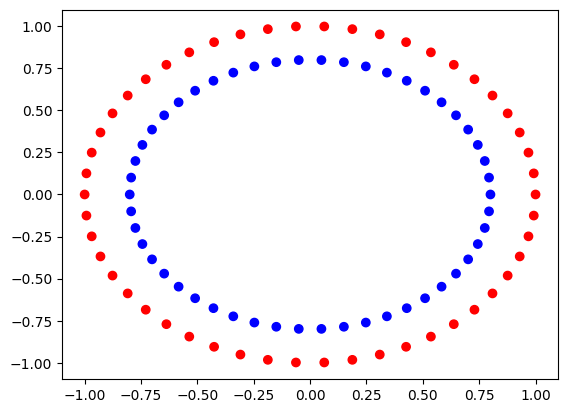

In [9]:
%matplotlib inline
col = {0:"r", 1:"b"}
plt.scatter(X[:,0], X[:,1], c=[col[i] for i in y])
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

## With noise 0

With a noise of 0, the function generates perfectly spaced and ordered points. Without any noise parameter, the data are perfectly separable and follow a clear pattern.

</div>

In [10]:
# Let's create a new dataset with some noise
n_samples = 600
noise = 0.2
factor = 0.25
newX, newy = make_circles(random_state=42, noise=noise, factor=factor, n_samples=n_samples)

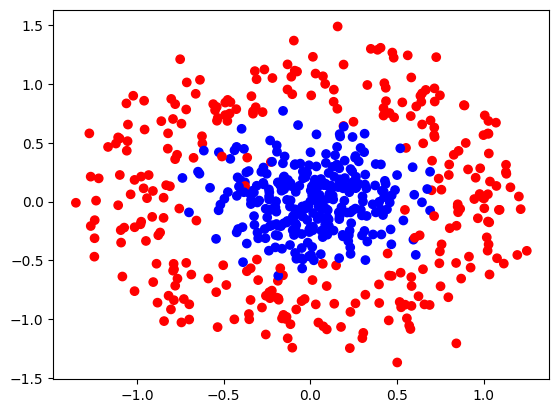

In [11]:
%matplotlib inline
col = {0:"r", 1:"b"}
plt.scatter(newX[:,0], newX[:,1], c=[col[i] for i in newy])
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

We can observe that with a noise level $> 0$, the points become more scattered and are no longer perfectly separable. Increasing the `factor` parameter also brings points from opposite classes closer together.

</div>

## Separating data into test and train dataset.

In [12]:
from sklearn.model_selection import train_test_split
# Using the point create before with : noise = 0.2, factor = 0.25 and n_samples = 600
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(newX, newy, test_size=0.3, random_state=42)


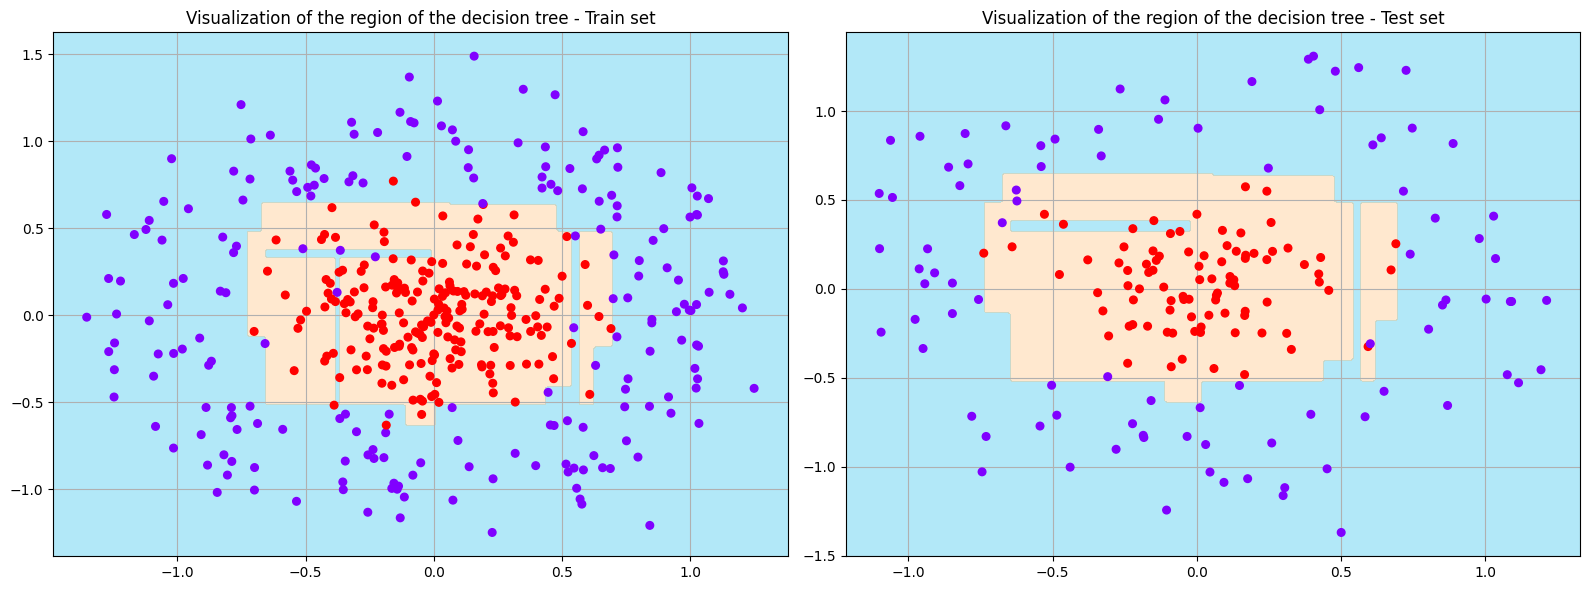

In [13]:
gen_model = tree.DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=48)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

gen_model.fit(X_train_gen, y_train_gen)
visualize_classifier(gen_model, X_train_gen, y_train_gen, ax=axes[0])
visualize_classifier(gen_model, X_test_gen, y_test_gen, ax=axes[1])
axes[0].set_title("Visualization of the region of the decision tree - Train set")
axes[1].set_title("Visualization of the region of the decision tree - Test set")

plt.tight_layout()
plt.show()

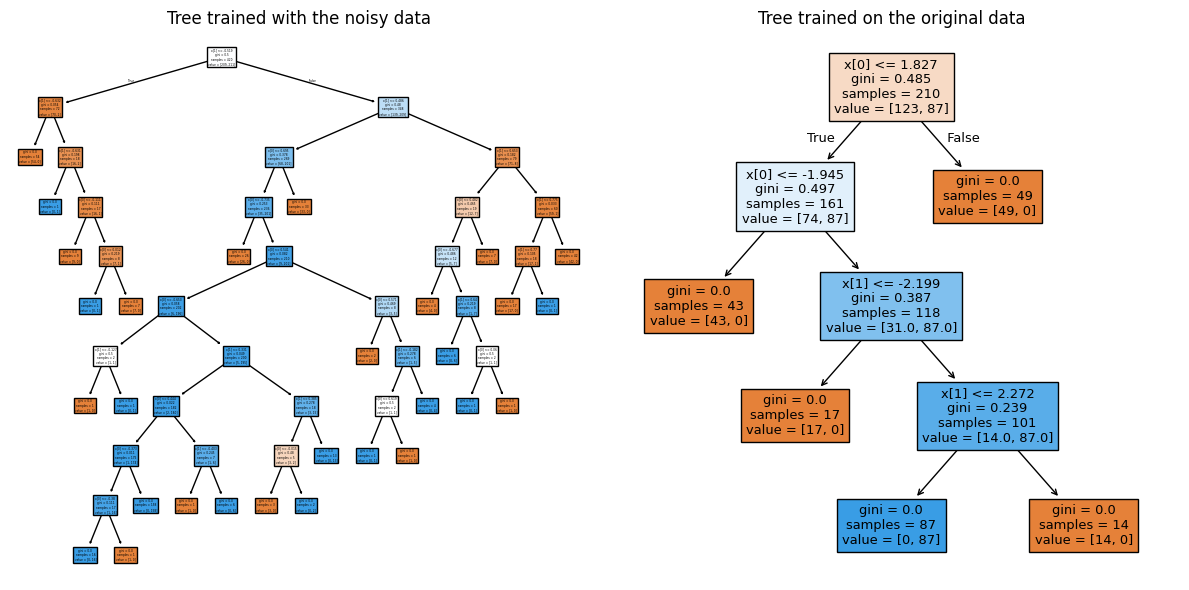

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

tree.plot_tree(gen_model, filled=True, ax=axes[0])
axes[0].set_title("Tree trained with the noisy data")

tree.plot_tree(model, filled=True, ax=axes[1])
axes[1].set_title("Tree trained on the original data")

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Computing the accuracy and confusion matrix (to have an idea of the misclassifications)
y_pred = gen_model.predict(X_test_gen)
generalization_error = 1 - accuracy_score(y_test_gen, y_pred)
conf_matrix = confusion_matrix(y_test_gen, y_pred)

print("Generalization error for new generated test set:", round(generalization_error, 2))
print("Confusion matrix for the new generated test set", conf_matrix)

## Let's compare with the previous model
y_pred_classic = model.predict(X_test.values)
generalization_error_classic = 1 - accuracy_score(y_test, y_pred_classic)
conf_matrix_classic = confusion_matrix(y_test, y_pred_classic)
print("Generalization error for eggoyke test set:", round(generalization_error_classic, 2))
print("Confusion matrix for the eggyoke test set", conf_matrix_classic)

Generalization error for new generated test set: 0.06
Confusion matrix for the new generated test set [[86  5]
 [ 5 84]]
Generalization error for eggoyke test set: 0.01
Confusion matrix for the eggyoke test set [[125   0]
 [  2  84]]


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

As we can see, the way the trees are generated is highly dependent on our data. In our first case, the original train dataset (eggoyoke) more separable produced a tree with a small depth and give a generalization error close to 0.
On the other hand, the decision tree created from the second generated dataset with a high bias and less separable class produced a much deeper tree with a greater generalization error.
</div>

## Creating new dataset with the same properties

In [16]:
# Creation of test set 
n_samples = 600
noise = 0.2
factor = 0.25
newX_v2, newy_v2 = make_circles(random_state=42, noise=noise, factor=factor, n_samples=n_samples)
X_train_gen2, X_test_gen2, y_train_gen2, y_test_gen2 = train_test_split(newX_v2, newy_v2, test_size=0.3, random_state=8)

# Creating and training a new model
gen_model_v2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=49)
gen_model_v2.fit(X_train_gen2, y_train_gen2)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",49
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

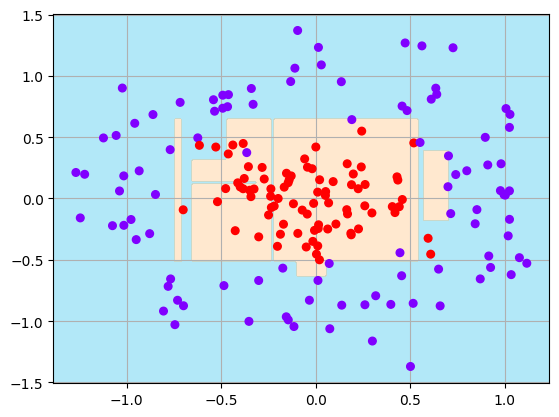

In [17]:
visualize_classifier(gen_model_v2, X_test_gen2, y_test_gen2)
plt.show()

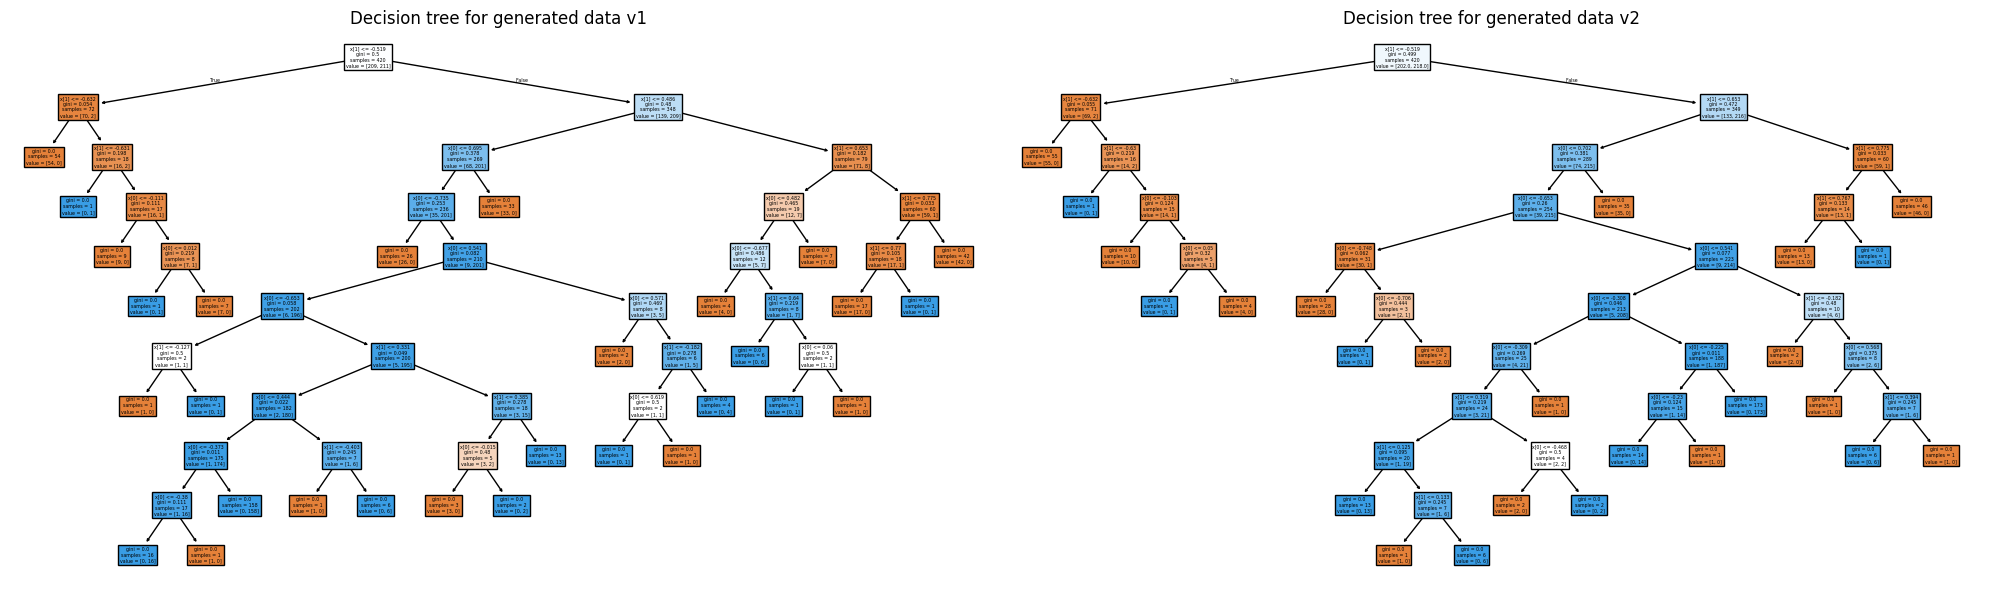

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

tree.plot_tree(gen_model, filled=True, ax=axes[0])
axes[0].set_title("Decision tree for generated data v1")

tree.plot_tree(gen_model_v2, filled=True, ax=axes[1])
axes[1].set_title("Decision tree for generated data v2")

plt.tight_layout()
plt.show()

### On the V1 of our generated data (noise = 0.2, factor = 0.25)

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Computing the accuracy and confusion matrix on the new model for both the new generated data : v1
y_pred = gen_model.predict(X_test_gen)
generalization_error = 1 - accuracy_score(y_test_gen, y_pred)
conf_matrix = confusion_matrix(y_test_gen, y_pred)
print("Generalization error of data gen 1 on model gen 1:", round(generalization_error, 2))
print("Confusion matrix of data gen 1 on model gen 1", conf_matrix)

y_pred = gen_model_v2.predict(X_test_gen)
generalization_error = 1 - accuracy_score(y_test_gen, y_pred)
conf_matrix = confusion_matrix(y_test_gen, y_pred)
print("Generalization error of data gen 1 on model gen 2:", round(generalization_error, 2))
print("Confusion matrix of data gen 1 on model gen 2", conf_matrix)

Generalization error of data gen 1 on model gen 1: 0.06
Confusion matrix of data gen 1 on model gen 1 [[86  5]
 [ 5 84]]
Generalization error of data gen 1 on model gen 2: 0.01
Confusion matrix of data gen 1 on model gen 2 [[91  0]
 [ 2 87]]


### On the V2 of our generated data (noise = 0.2, factor = 0.25)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Computing the accuracy and confusion matrix on the new model for both the new generated data : v2
y_pred = gen_model.predict(X_test_gen2)
generalization_error = 1 - accuracy_score(y_test_gen2, y_pred)
conf_matrix = confusion_matrix(y_test_gen2, y_pred)
print("Generalization error of data gen 2 on model gen 1:", round(generalization_error, 2))
print("Confusion matrix of data gen 2 on model gen 1", conf_matrix)

y_pred = gen_model_v2.predict(X_test_gen2)
generalization_error = 1 - accuracy_score(y_test_gen2, y_pred)
conf_matrix = confusion_matrix(y_test_gen2, y_pred)
print("Generalization error of data gen 2 on model gen 2:", round(generalization_error, 2))
print("Confusion matrix of data gen 2 on model gen 2", conf_matrix)

Generalization error of data gen 2 on model gen 1: 0.02
Confusion matrix of data gen 2 on model gen 1 [[97  1]
 [ 2 80]]
Generalization error of data gen 2 on model gen 2: 0.07
Confusion matrix of data gen 2 on model gen 2 [[91  7]
 [ 6 76]]


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

We observed significant differences in the decision trees. This shows that decision trees remain dependent on the input data and sensitive to even small changes.

</div>

# Question 4

#### 1. Using numpy randint, boostrap the train set to obtained two resampled train sets of size 3/4th that of the original dataset. Fit a tree in each resampled train set, visualize and compute generalization error. Combine the decision of both predictors and compute generalization error of the combination.

## With the original dataset

In [21]:
import numpy as np
X__boot_train = X_train.values.copy()
y_boot_train = y_train.values.copy()

# I set the seed to have reproducible results, but this not give you twice the same bootstrap samples
np.random.seed(10)

N = len(X__boot_train) 
bootstrap_indices = np.random.choice(N, size=3*N//4, replace=True)
X1_bootstrap = X__boot_train[bootstrap_indices]
y1_bootstrap = y_boot_train[bootstrap_indices]

bootstrap_indices = np.random.choice(N, size=3*N//4, replace=True)
X2_bootstrap = X__boot_train[bootstrap_indices]
y2_bootstrap = y_boot_train[bootstrap_indices]

# We verify that the generated data are different.
print("First bootstrap sample size:", X1_bootstrap[:10])
print("Second bootstrap sample size:", X2_bootstrap[:10])

First bootstrap sample size: [[ 4.35518546 -1.31769043]
 [-0.96370616  0.29140668]
 [-5.23326724 -1.14308946]
 [-4.88847549 -2.05110212]
 [-1.6144703  -4.35714099]
 [ 1.68952277  0.59378722]
 [ 0.90142424 -0.09145551]
 [ 0.1554819   0.71102435]
 [-1.6144703  -4.35714099]
 [-0.32605768 -3.04999207]]
Second bootstrap sample size: [[ 3.25830353  3.62366915]
 [ 0.1994879  -1.37521026]
 [ 1.73279352  0.86388703]
 [-7.93836784 -1.47667408]
 [ 1.8244243   0.6692468 ]
 [ 3.98953244  2.66874955]
 [ 0.7046745   0.06080009]
 [-0.98187204 -5.4910814 ]
 [ 1.8244243   0.6692468 ]
 [-1.95193631  6.18272203]]


### Let's fit 2 different tree

Text(0.5, 1.0, 'Bootstrap model 2 - eggyoke dataset')

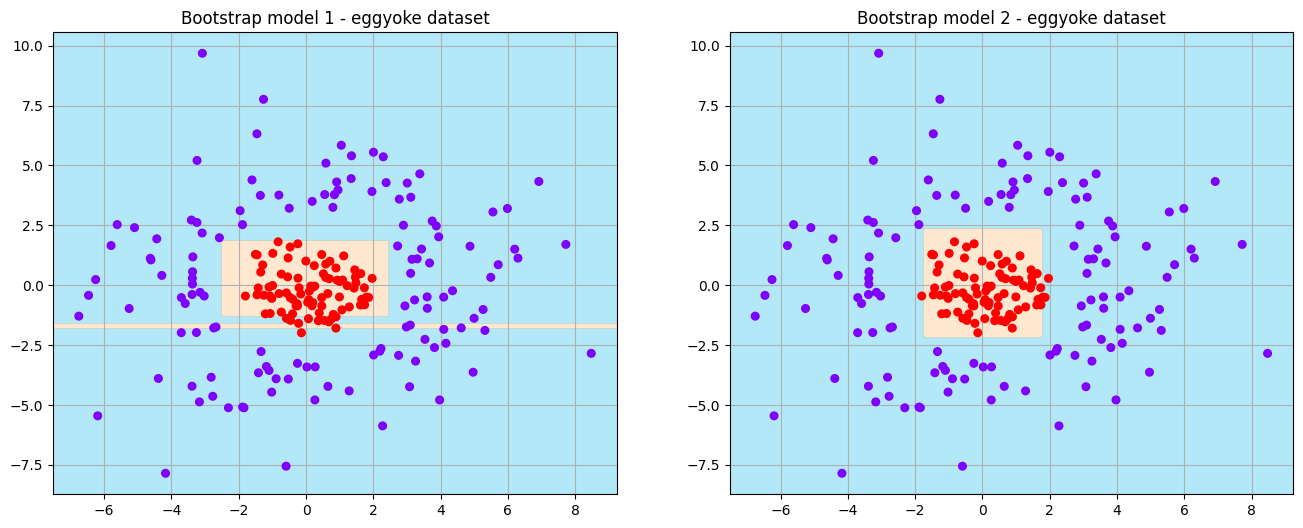

In [22]:
bootstrap_model1 = tree.DecisionTreeClassifier(criterion='gini', max_depth=15)
bootstrap_model1.fit(X1_bootstrap, y1_bootstrap)

bootstrap_model2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=15)
bootstrap_model2.fit(X2_bootstrap, y2_bootstrap)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
visualize_classifier(bootstrap_model1, X_test.values, y_test, ax=axes[0])
axes[0].set_title("Bootstrap model 1 - eggyoke dataset")
visualize_classifier(bootstrap_model2, X_test.values, y_test, ax=axes[1])
axes[1].set_title("Bootstrap model 2 - eggyoke dataset")

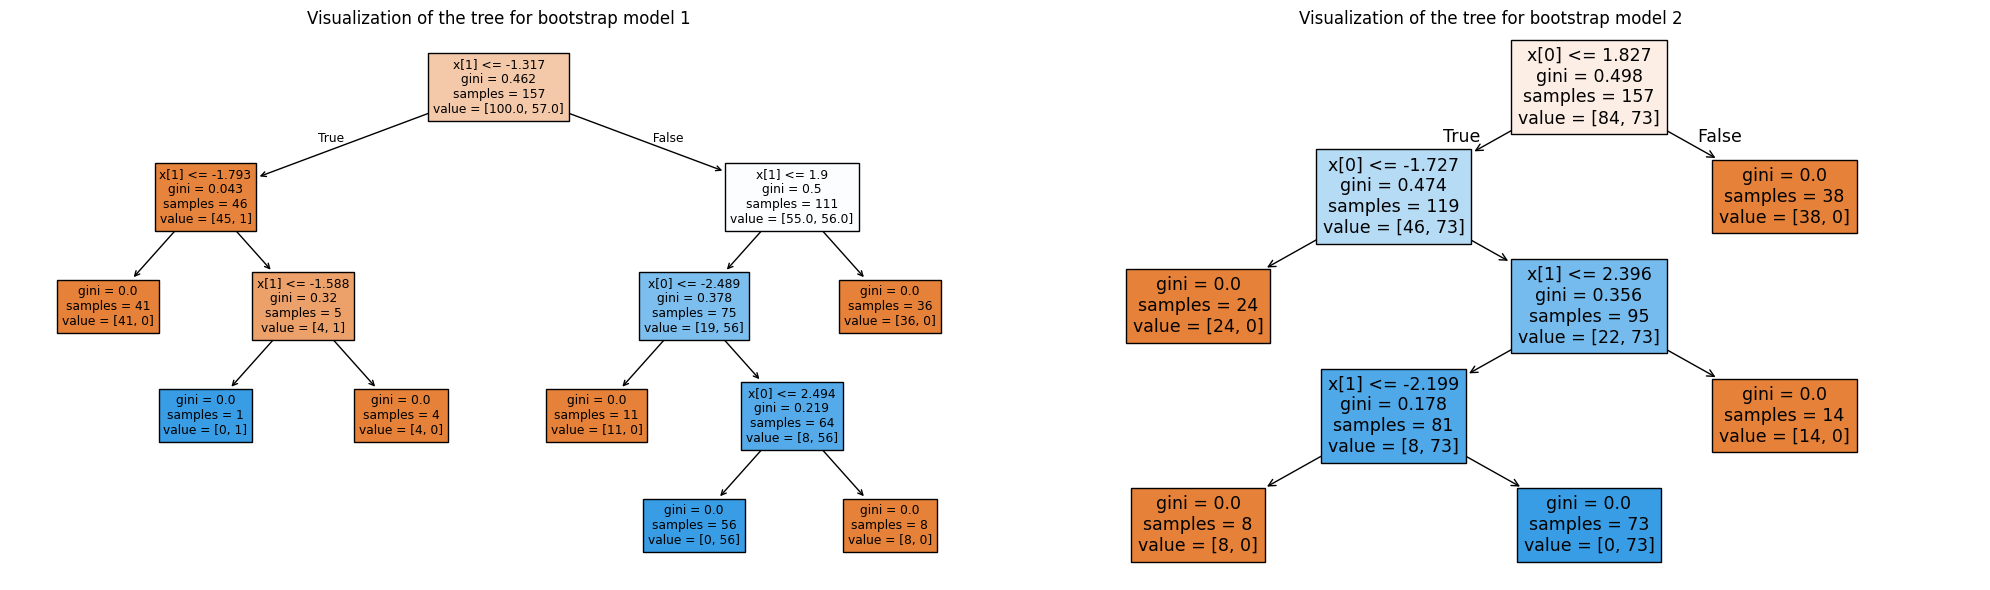

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

tree.plot_tree(bootstrap_model1, filled=True, ax=axes[0])
axes[0].set_title("Visualization of the tree for bootstrap model 1")

tree.plot_tree(bootstrap_model2, filled=True, ax=axes[1])
axes[1].set_title("Visualization of the tree for bootstrap model 2")

plt.tight_layout()
plt.show()

### Generalization error

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Computing the accuracy and confusion matrix for both our model
## Model 1
y_pred1 = bootstrap_model1.predict(X_test.values)
generalization_error_1 = 1 - accuracy_score(y_test, y_pred1)
conf_matrix1 = confusion_matrix(y_test, y_pred1)

## Model 2
y_pred2 = bootstrap_model2.predict(X_test.values)
generalization_error_2 = 1 - accuracy_score(y_test, y_pred2)
conf_matrix2 = confusion_matrix(y_test, y_pred2)

print("Bootstrap Model 1 - Generalization error:", round(generalization_error_1, 2))
print("Bootstrap Model 1 - Confusion matrix", conf_matrix1)

print("Bootstrap Model 2 - Generalization error:", round(generalization_error_2, 2))
print("Bootstrap Model 2 - Confusion matrix", conf_matrix2)

Bootstrap Model 1 - Generalization error: 0.07
Bootstrap Model 1 - Confusion matrix [[120   5]
 [  9  77]]
Bootstrap Model 2 - Generalization error: 0.01
Bootstrap Model 2 - Confusion matrix [[125   0]
 [  3  83]]


In [25]:
# Give combined prediction of both bootstrap models
from scipy.stats import mode
y_pred1 = bootstrap_model1.predict(X_test.values)
y_pred2 = bootstrap_model2.predict(X_test.values)
y_pred_combined = mode(np.array([y_pred1, y_pred2]), axis=0)[0]
combined_accuracy = accuracy_score(y_test, y_pred_combined.flatten())
print("Combined Bootstrap Models - Generalization error:", round(1 - combined_accuracy, 2))

Combined Bootstrap Models - Generalization error: 0.06


In [26]:
# Adding more bootstrap models could improve the performance
def homemade_bagging_predict(X_train, y_train, X_test, n_models=5):
    from scipy.stats import mode
    N = len(X_train)
    predictions = []
    for i in range(n_models):
        bootstrap_indices = np.random.choice(N, size=3*N//4, replace=True)
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        model = tree.DecisionTreeClassifier(criterion='gini')
        model.fit(X_bootstrap, y_bootstrap)
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
    
    # This make the majority vote
    combined_predictions = mode(np.array(predictions), axis=0)[0]
    return combined_predictions.flatten()

y_pred_bagging = homemade_bagging_predict(X__boot_train, y_boot_train, X_test.values, n_models=2)
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print("Homemade Bagging - Combined generalization error 2 model:", round(1 - bagging_accuracy, 2))

y_pred_bagging = homemade_bagging_predict(X__boot_train, y_boot_train, X_test.values, n_models=10)
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print("Homemade Bagging - Combined generalization error 10 model:", round(1 - bagging_accuracy, 2))

Homemade Bagging - Combined generalization error 2 model: 0.01
Homemade Bagging - Combined generalization error 10 model: 0.0


## For one of our generated dataset

In [27]:
# Trying bagging with 2 models
y_pred_bagging = homemade_bagging_predict(X_train_gen, y_train_gen, X_test_gen, n_models=2)
bagging_accuracy = accuracy_score(y_test_gen, y_pred_bagging)
print("Homemade Bagging - Combined generalization error 2 model:", round(1 - bagging_accuracy, 2))

# Trying bagging with 10 models
y_pred_bagging = homemade_bagging_predict(X_train_gen, y_train_gen, X_test_gen, n_models=10)
bagging_accuracy = accuracy_score(y_test_gen, y_pred_bagging)
print("Homemade Bagging - Combined generalization error 10 model:", round(1 - bagging_accuracy, 2))

Homemade Bagging - Combined generalization error 2 model: 0.07
Homemade Bagging - Combined generalization error 10 model: 0.04


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">
So we can see this show us a better generalization power.  
At 2 model the generalization error is 0.07, which is not suprising because with only 2 models the prediction will always be focus on 1 model.  
At 10 the generalization error is lower than previously and goes to 0.01. 
This show the importance of method of boosting such as the bagging to improve the generalization power of our model.
</div>

### Bagging Classifier

## For generated dataset

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

bag = BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(criterion='gini'),
    n_estimators= 100,
    max_samples=0.75,
    bootstrap=True,
)

bag.fit(X_train_gen, y_train_gen)


,"estimator estimator: object, default=NoneThe base estimator to fit on random subsets of the dataset.If None, then the base estimator is a:class:`~sklearn.tree.DecisionTreeClassifier`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeClassifier()
,"n_estimators n_estimators: int, default=10The number of base estimators in the ensemble.",100
,"max_samples max_samples: int or float, default=NoneThe number of samples to draw from X to train each base estimator (withreplacement by default, see `bootstrap` for more details).- If None, then draw `X.shape[0]` samples irrespective of `sample_weight`.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` unweighted samples or `max_samples * sample_weight.sum()` weighted samples.",0.75
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator (without replacement by default, see `bootstrap_features` for moredetails).- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.",1.0
,"bootstrap bootstrap: bool, default=TrueWhether samples are drawn with replacement. If False, sampling withoutreplacement is performed. If fitting with `sample_weight`, it isstrongly recommended to choose True, as only drawing with replacementwill ensure the expected frequency semantics of `sample_weight`.",True
,"bootstrap_features bootstrap_features: bool, default=FalseWhether features are drawn with replacement.",False
,"oob_score oob_score: bool, default=FalseWhether to use out-of-bag samples to estimatethe generalization error. Only available if bootstrap=True.",False
,"warm_start warm_start: bool, default=FalseWhen set to True, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fita whole new ensemble. See :term:`the Glossary `... versionadded:: 0.17 *warm_start* constructor parameter.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for both :meth:`fit` and:meth:`predict`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random resampling of the original dataset(sample wise and feature wise).If the base estimator accepts a `random_state` attribute, a differentseed is generated for each instance in the ensemble.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"verbose verbose: int, default=0Controls the verbosity when fitting and predicting.",0


Bagging generalization error : dataset generated 1: 0.05


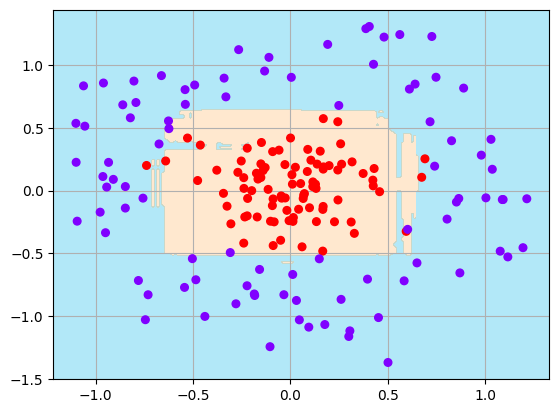

In [29]:
y_pred_generated = bag.predict(X_test_gen)
print("Bagging generalization error : dataset generated 1:", round(1 - accuracy_score(y_test_gen, y_pred_generated), 2))
visualize_classifier(bag, X_test_gen, y_test_gen)
plt.show()

## For original dataset

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

bag = BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(criterion='gini'),
    n_estimators= 100,
    max_samples=0.75,
    bootstrap=True,
    random_state=10,
)

bag.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator to fit on random subsets of the dataset.If None, then the base estimator is a:class:`~sklearn.tree.DecisionTreeClassifier`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeClassifier()
,"n_estimators n_estimators: int, default=10The number of base estimators in the ensemble.",100
,"max_samples max_samples: int or float, default=NoneThe number of samples to draw from X to train each base estimator (withreplacement by default, see `bootstrap` for more details).- If None, then draw `X.shape[0]` samples irrespective of `sample_weight`.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` unweighted samples or `max_samples * sample_weight.sum()` weighted samples.",0.75
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator (without replacement by default, see `bootstrap_features` for moredetails).- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.",1.0
,"bootstrap bootstrap: bool, default=TrueWhether samples are drawn with replacement. If False, sampling withoutreplacement is performed. If fitting with `sample_weight`, it isstrongly recommended to choose True, as only drawing with replacementwill ensure the expected frequency semantics of `sample_weight`.",True
,"bootstrap_features bootstrap_features: bool, default=FalseWhether features are drawn with replacement.",False
,"oob_score oob_score: bool, default=FalseWhether to use out-of-bag samples to estimatethe generalization error. Only available if bootstrap=True.",False
,"warm_start warm_start: bool, default=FalseWhen set to True, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fita whole new ensemble. See :term:`the Glossary `... versionadded:: 0.17 *warm_start* constructor parameter.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for both :meth:`fit` and:meth:`predict`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random resampling of the original dataset(sample wise and feature wise).If the base estimator accepts a `random_state` attribute, a differentseed is generated for each instance in the ensemble.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",10
,"verbose verbose: int, default=0Controls the verbosity when fitting and predicting.",0


Bagging generalization error : eggyoke dataset: 0.0


/home/gwenn/Desktop/MachineLearningLab-MasterDataScience/.env/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


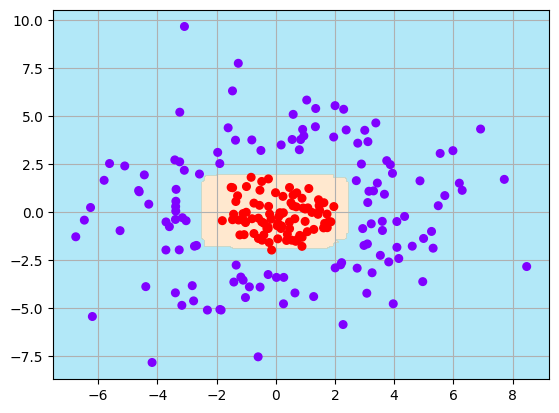

In [31]:
y_pred = bag.predict(X_test)
print("Bagging generalization error : eggyoke dataset:", round(1 - accuracy_score(y_test, y_pred), 2))
visualize_classifier(bag, X_test.values, y_test)
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0;">

Finally, during this lab, we observed that decision trees are highly dependent on the input data. Indeed, a decision tree does not necessarily provide a globally optimal solution, but rather a solution that depends on local decisions made during its construction. Moreover, data separability plays a crucial role in determining model complexity: poorly separable data tend to produce deep and complex trees, whereas well-separable data allow for simpler tree structures.

This highlights the interest of **bootstrap**, which makes it possible to randomly generate multiple datasets from the original training set, allowing the training of different models that solve the same problem. The use of multiple models trained on similar data then allows, through a majority voting mechanism, the selection of the most probable class.

This approach, based on the combination of predictions from several models called **bagging**, generally improves generalization performance, particularly for models that exhibit high initial variance.

As we can see, this improve for the generated dataset (poorly separable) the generalization power, and lead to a prediction error of 0 for the eggyoke dataset (more separable).
</div>